In [1]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(40)
# Set the seed for TensorFlow
tf.random.set_seed(40)
import datetime as dt

In [2]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [3]:
# Checking the contents of xrays folder
data_dir = "data/AugmentedAlzheimerDataset/"
data_dir

'data/AugmentedAlzheimerDataset/'

In [4]:
# Getting the list of folders from data dir
subfolders = os.listdir(data_dir)
subfolders

['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']

In [5]:
# Getting list of img file paths (no folders)
img_files = glob.glob(data_dir+"**/*")
len(img_files)

33984

In [6]:
# Take a look at the first 5 filepaths
img_files[0:5]

['data/AugmentedAlzheimerDataset/VeryMildDemented/2b70a7c4-b97a-4887-8e5f-85c079e7b275.jpg',
 'data/AugmentedAlzheimerDataset/VeryMildDemented/59bfe517-a5b4-4dd3-8e32-07fba7a77aa9.jpg',
 'data/AugmentedAlzheimerDataset/VeryMildDemented/ef1d73c2-679f-4421-b7c5-06881d487cf0.jpg',
 'data/AugmentedAlzheimerDataset/VeryMildDemented/716c42f4-f92c-40cd-9088-6254973a6665.jpg',
 'data/AugmentedAlzheimerDataset/VeryMildDemented/f897246c-1263-479b-8fe0-351e98cf7c9c.jpg']

In [7]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(190, 200, 3)

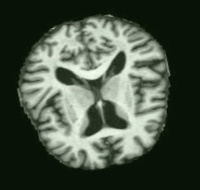

In [8]:
# Data can be converted back to image
array_to_img(img_data)

In [9]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 128
img_width = 128

In [10]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds

Found 33984 files belonging to 4 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [11]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

1062

In [12]:
# taking a sample batch to see batch shape
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 128, 128, 3])

In [13]:
# Preview y for first 5 of first batch
example_batch_y[0:5]

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

In [18]:
# checking the class names
class_names = ds.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [19]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

4

In [20]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

In [21]:
# Individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([128, 128, 3])

In [22]:
# Demo Unpacking shape
input_shape = [*input_shape]
input_shape

[128, 128, 3]

In [23]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.1
split_test = 0.2
# Calculate the number of batches for training and validation data
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 743 batches as training data
Use 106 batches as validation data
The remaining 213 batches will be used as test data.


In [24]:
# Use .take to slice out the number of batches
train_ds = ds.take(n_train_batches)
# Confirm the length of the training set
len(train_ds)

743

In [25]:
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
len(val_ds)

106

In [26]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
len(test_ds)

213

In [27]:
# The original (non-take/non-skip) dataset contains the class_names
class_names  = ds.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [28]:
# Use autotune to automatically determine best buffer sizes
AUTOTUNE = tf.data.AUTOTUNE

In [29]:
# Make buffer size the same as the number of batches in train_ds
buffer_size = len(train_ds)
buffer_size

743

In [30]:
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   seed=40).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []

    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():

        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred_probs

In [32]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [34]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")


    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [36]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")


    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [37]:
def evaluate_classification_network(model,
                                    X_train=None, y_train=None,
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f",
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')

        ## Run model.evaluate
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))

    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')

        ## Run model.evaluate
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))

    # If no X_test, then save empty list for results_test
    else:
        results_test = []

    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

In [38]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=4))  # Size of pooling
    model.add(layers.Dense(input_shape[1],kernel_regularizer=regularizers.l2(0.04),activation="relu")) # R2 regularizer
    model.add(layers.Dropout(0.4))  # Dropout layer
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=3))  # Size of pooling
    model.add(layers.Dense(input_shape[1],kernel_regularizer=regularizers.l2(0.04),activation="relu")) # R2 regularizer
    model.add(layers.Dropout(0.4))  # Dropout layer
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(4, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model



In [39]:
model10 = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 8)         0         
 D)                                                              
                                                                 
 dense (Dense)               (None, 32, 32, 128)       1152      
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         9224      
                                                        

In [40]:
start = dt.datetime.now()
# fit the neural network
epochs=10
history = model10.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")

Epoch 1/10
743/743 [==============================] - 57s 72ms/step - loss: 1.3843 - accuracy: 0.3902 - val_loss: 1.1287 - val_accuracy: 0.5027
Epoch 2/10
743/743 [==============================] - 50s 67ms/step - loss: 1.1018 - accuracy: 0.5172 - val_loss: 1.0058 - val_accuracy: 0.5716
Epoch 3/10
743/743 [==============================] - 53s 71ms/step - loss: 1.0344 - accuracy: 0.5476 - val_loss: 0.9685 - val_accuracy: 0.5743
Epoch 4/10
743/743 [==============================] - 50s 67ms/step - loss: 0.9902 - accuracy: 0.5657 - val_loss: 0.9398 - val_accuracy: 0.5887
Epoch 5/10
743/743 [==============================] - 52s 70ms/step - loss: 0.9620 - accuracy: 0.5800 - val_loss: 0.8881 - val_accuracy: 0.6159
Epoch 6/10
743/743 [==============================] - 55s 73ms/step - loss: 0.9363 - accuracy: 0.5911 - val_loss: 0.9137 - val_accuracy: 0.6082
Epoch 7/10
743/743 [==============================] - 54s 73ms/step - loss: 0.9177 - accuracy: 0.5980 - val_loss: 0.8678 - val_accuracy:

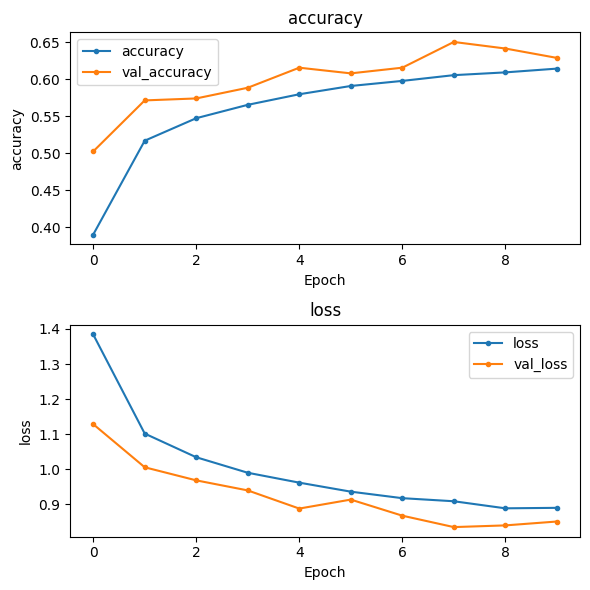


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.76      0.64      1795
           1       0.96      0.86      0.91      1311
           2       0.57      0.76      0.65      1936
           3       0.54      0.18      0.27      1774

    accuracy                           0.63      6816
   macro avg       0.66      0.64      0.62      6816
weighted avg       0.63      0.63      0.60      6816



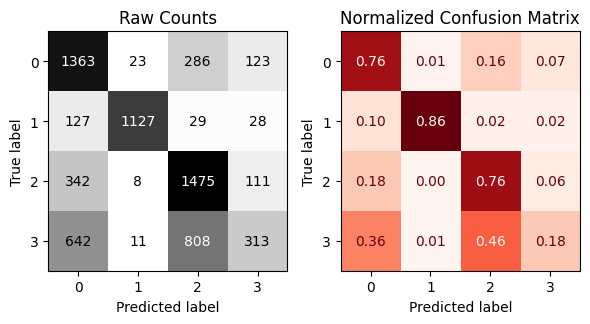


- Evaluating Test Data:
213/213 [==============================] - 4s 18ms/step - loss: 0.8509 - accuracy: 0.6276
{'loss': 0.8508736491203308, 'accuracy': 0.6276408433914185}


/Users/khaled/Learning/computer-vision-sample/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
# Testing with the CNN + Dataset
evaluate_classification_network(model10, X_test=test_ds, history=history);
model10.save('model10.h5')

In [ ]:
start = dt.datetime.now()
# fit the neural network
epochs=20
history = model10.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")
# Testing with the CNN + Dataset
evaluate_classification_network(model10, X_test=test_ds, history=history);
model10.save('model10_pt2.h5')

In [ ]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=4,  # How many filters you want to use
            kernel_size=4,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=4))  # Size of pooling
    model.add(layers.Dense(input_shape[1],kernel_regularizer=regularizers.l2(0.01),activation="relu")) # R2 regularizer
    model.add(layers.Dropout(0.2))  # Dropout layer
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=4,  # How many filters you want to use
            kernel_size=4,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=4))  # Size of pooling
    model.add(layers.Dropout(0.2))  # Dropout layer
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=4,  # How many filters you want to use
            kernel_size=4,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=4))  # Size of pooling
    # Flattening layer
    model.add(layers.Dense(input_shape[1],kernel_regularizer=regularizers.l2(0.01),activation="relu")) # R2 regularizer
    model.add(layers.Dropout(0.3))  # Dropout layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(4, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

model11 = build_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 190, 200, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 190, 200, 4)       196       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 47, 50, 4)         0         
 ng2D)                                                           
                                                                 
 dense_12 (Dense)            (None, 47, 50, 200)       1000      
                                                                 
 dropout_8 (Dropout)         (None, 47, 50, 200)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 47, 50, 4)         12804     
                                                      

Epoch 1/20


2024-02-06 01:31:26.291335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:3029: Filling up shuffle buffer (this may take a while): 378 of 743
2024-02-06 01:31:36.813760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-02-06 01:31:36.813930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:3036: Filling up shuffle buffer (this may take a while): 1 of 743
2024-02-06 01:31:36.876199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


743/743 [==============================] - 919s 1s/step - loss: 1.3264 - accuracy: 0.3699 - val_loss: 1.1643 - val_accuracy: 0.4847
Epoch 2/20
743/743 [==============================] - 900s 1s/step - loss: 1.1583 - accuracy: 0.4761 - val_loss: 1.0483 - val_accuracy: 0.5460
Epoch 3/20
743/743 [==============================] - 904s 1s/step - loss: 1.0683 - accuracy: 0.5193 - val_loss: 0.9720 - val_accuracy: 0.5740
Epoch 4/20
743/743 [==============================] - 875s 1s/step - loss: 1.0202 - accuracy: 0.5465 - val_loss: 0.9974 - val_accuracy: 0.5336
Epoch 5/20
743/743 [==============================] - 867s 1s/step - loss: 0.9870 - accuracy: 0.5581 - val_loss: 0.8941 - val_accuracy: 0.5994
Epoch 6/20
743/743 [==============================] - 928s 1s/step - loss: 0.9659 - accuracy: 0.5672 - val_loss: 0.8851 - val_accuracy: 0.6014
Epoch 7/20
743/743 [==============================] - 947s 1s/step - loss: 0.9512 - accuracy: 0.5723 - val_loss: 0.8567 - val_accuracy: 0.6191
Epoch 8/20

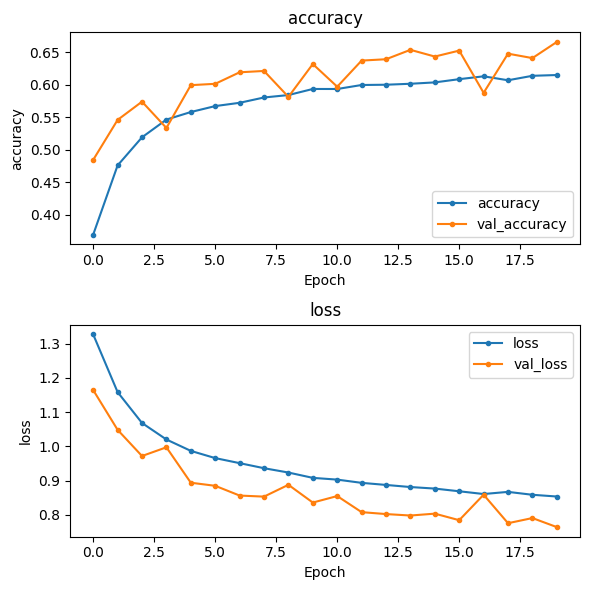


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.85      0.69      1795
           1       0.92      0.96      0.94      1311
           2       0.68      0.69      0.69      1936
           3       0.62      0.30      0.41      1774

    accuracy                           0.68      6816
   macro avg       0.70      0.70      0.68      6816
weighted avg       0.69      0.68      0.66      6816



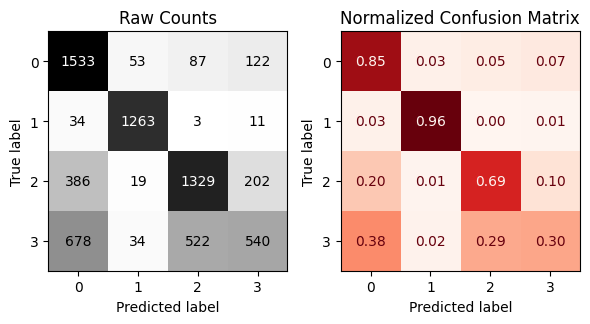


- Evaluating Test Data:
213/213 [==============================] - 64s 298ms/step - loss: 0.7256 - accuracy: 0.6844
{'loss': 0.7255548238754272, 'accuracy': 0.6844190359115601}


/usr/local/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
start = dt.datetime.now()
# fit the neural network
epochs=20
history = model11.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")
# Testing with the CNN + Dataset
evaluate_classification_network(model10, X_test=test_ds, history=history);
model10.save('model10_pt2.h5')

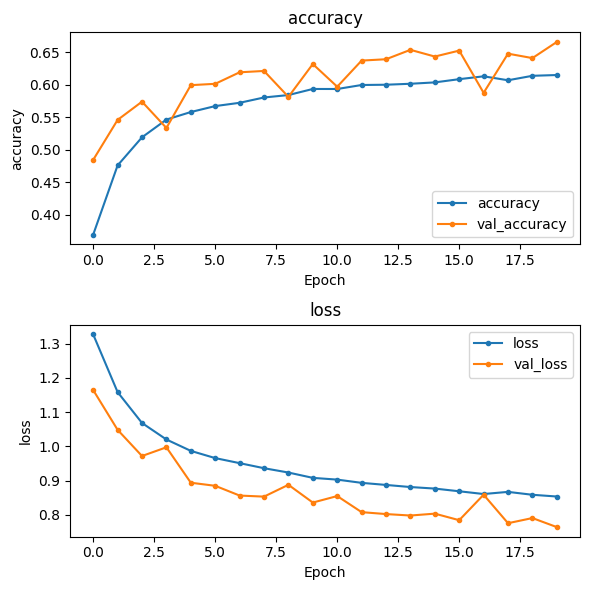


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.74      0.64      1795
           1       0.95      0.95      0.95      1311
           2       0.68      0.66      0.67      1936
           3       0.52      0.37      0.43      1774

    accuracy                           0.66      6816
   macro avg       0.68      0.68      0.67      6816
weighted avg       0.66      0.66      0.66      6816



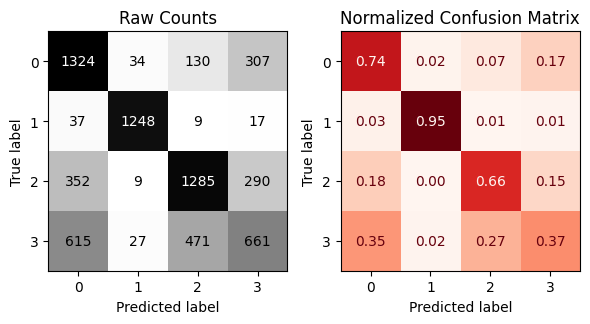


- Evaluating Test Data:
213/213 [==============================] - 72s 337ms/step - loss: 0.7712 - accuracy: 0.6629
{'loss': 0.7712499499320984, 'accuracy': 0.6628521084785461}


/usr/local/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model11, X_test=test_ds, history=history);
model11.save('model11_1.h5')

In [ ]:
start = dt.datetime.now()
# fit the neural network
epochs=20
history = model11.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")
# Testing with the CNN + Dataset
evaluate_classification_network(model11, X_test=test_ds, history=history);
model11.save('model11_2.h5')

Epoch 1/20
743/743 [==============================] - 1578s 2s/step - loss: 0.8537 - accuracy: 0.6152 - val_loss: 0.7847 - val_accuracy: 0.6374
Epoch 2/20
743/743 [==============================] - 1549s 2s/step - loss: 0.8546 - accuracy: 0.6124 - val_loss: 0.8278 - val_accuracy: 0.5991
Epoch 3/20
743/743 [==============================] - 856s 1s/step - loss: 0.8509 - accuracy: 0.6162 - val_loss: 0.8207 - val_accuracy: 0.6165
Epoch 4/20
743/743 [==============================] - 802s 1s/step - loss: 0.8431 - accuracy: 0.6196 - val_loss: 0.7876 - val_accuracy: 0.6374
Epoch 5/20
743/743 [==============================] - 802s 1s/step - loss: 0.8460 - accuracy: 0.6176 - val_loss: 0.7696 - val_accuracy: 0.6465
Epoch 6/20
743/743 [==============================] - 800s 1s/step - loss: 0.8361 - accuracy: 0.6266 - val_loss: 0.7568 - val_accuracy: 0.6651
Epoch 7/20
743/743 [==============================] - 1090s 1s/step - loss: 0.8384 - accuracy: 0.6189 - val_loss: 0.7917 - val_accuracy: 0.6

In [ ]:
start = dt.datetime.now()
# fit the neural network
epochs=20
history = model11.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")
# Testing with the CNN + Dataset
evaluate_classification_network(model11, X_test=test_ds, history=history);
model11.save('model11_3.h5')

In [42]:
from tensorflow.keras import models, layers, regularizers

def build_improved_model(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))

    # Convolutional layers
    model.add(layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(filters=248, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers with dropout and regularization
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
    model.add(layers.Dropout(0.6))

    # Output layer
    model.add(layers.Dense(4, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    return model

# Example usage:
input_shape = (128, 128, 3)  # Assuming input shape based on the original model
improved_model = build_improved_model(input_shape)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)       

Epoch 1/20
995/995 [==============================] - 272s 272ms/step - loss: 3.7290 - accuracy: 0.4664 - val_loss: 0.8308 - val_accuracy: 0.6602
Epoch 2/20
995/995 [==============================] - 273s 274ms/step - loss: 0.7578 - accuracy: 0.6777 - val_loss: 0.6060 - val_accuracy: 0.7445
Epoch 3/20
995/995 [==============================] - 266s 267ms/step - loss: 0.5988 - accuracy: 0.7579 - val_loss: 0.5035 - val_accuracy: 0.7993
Epoch 4/20
995/995 [==============================] - 265s 266ms/step - loss: 0.5133 - accuracy: 0.8014 - val_loss: 0.4540 - val_accuracy: 0.8200
Epoch 5/20
995/995 [==============================] - 268s 269ms/step - loss: 0.4543 - accuracy: 0.8372 - val_loss: 0.4289 - val_accuracy: 0.8484
Epoch 6/20
995/995 [==============================] - 256s 257ms/step - loss: 0.3919 - accuracy: 0.8648 - val_loss: 0.3521 - val_accuracy: 0.8838
Epoch 7/20
995/995 [==============================] - 254s 255ms/step - loss: 0.3596 - accuracy: 0.8868 - val_loss: 0.3753 -

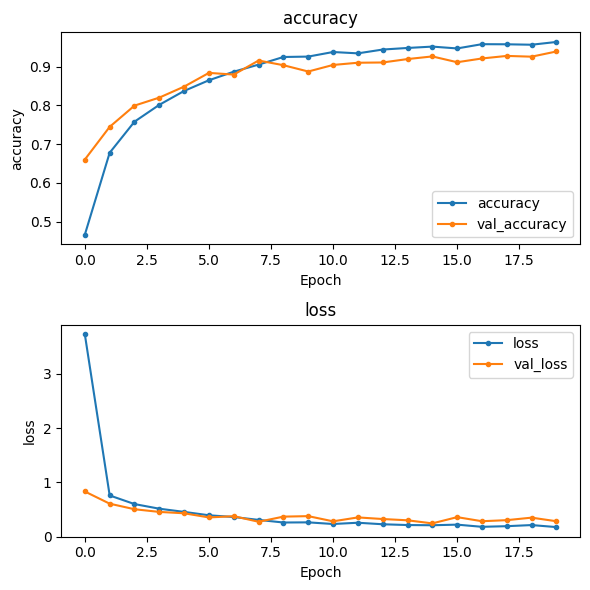


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2377
           1       0.99      1.00      1.00      1831
           2       0.91      0.94      0.92      2506
           3       0.89      0.89      0.89      2405

    accuracy                           0.93      9119
   macro avg       0.94      0.94      0.94      9119
weighted avg       0.93      0.93      0.93      9119



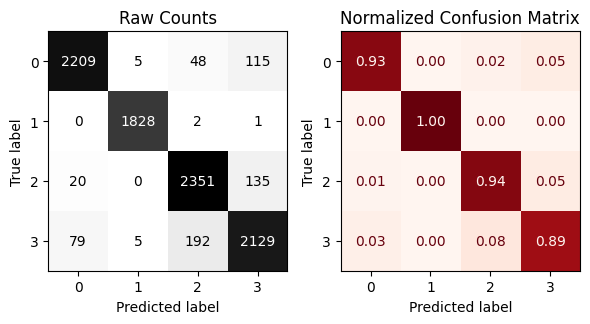


- Evaluating Test Data:
285/285 [==============================] - 17s 59ms/step - loss: 0.2993 - accuracy: 0.9340
{'loss': 0.2992894947528839, 'accuracy': 0.9339839816093445}


/usr/local/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
start = dt.datetime.now()
# fit the neural network
epochs=20
history = improved_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")
# Testing with the CNN + Dataset
evaluate_classification_network(improved_model, X_test=test_ds, history=history);
improved_model.save('improved_model_4.keras')